# (2주차) 9월14일, 9월16일
> 파이토치를 이용하여 회귀모형 학습하기

- toc:true
- branch: master
- badges: true
- comments: true
- author: 최규빈

### 강의영상 

> youtube: https://youtube.com/playlist?list=PLQqh36zP38-xeN8okLLl20-kJruSR44gX

`-` (1/5) 회귀모형 소개, 손실 함수

`-` (2/5) 경사하강법, 경사하강법을 이용하여 회귀계수 1회 업데이트

`-` (3/5) 회귀계수 반복 업데이트 

`-` (4/5) 학습률

`-` (5/5) 사과영상 

### import 

In [1]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt 

### 로드맵

`-` 회귀분석 $\to$ 로지스틱 $\to$ 심층신경망(DNN) $\to$ 합성곱신경망(CNN) 

### Data

`-` model: $y_i= w_0+w_1 x_i +\epsilon_i = 2.5 + 4x_i +\epsilon_i, \quad i=1,2,\dots,n$ 

`-` model: ${\bf y}={\bf X}{\bf W} +\boldsymbol{\epsilon}$

- ${\bf y}=\begin{bmatrix} y_1 \\ y_2 \\ \dots \\ y_n\end{bmatrix}, \quad {\bf X}=\begin{bmatrix} 1 & x_1 \\ 1 & x_2 \\ \dots \\ 1 & x_n\end{bmatrix}, \quad {\bf W}=\begin{bmatrix} 2.5 \\ 4 \end{bmatrix}, \quad \boldsymbol{\epsilon}= \begin{bmatrix} \epsilon_1 \\ \dots \\ \epsilon_n\end{bmatrix}$

In [2]:
torch.manual_seed(43052)
n=100
ones= torch.ones(n)
x,_ = torch.randn(n).sort()
# torch.randn(n)을 하면 앞은 tensor, 뒤는 index 이므로 tensor만 받아온다.
X = torch.vstack([ones,x]).T
W = torch.tensor([2.5,4])
ϵ = torch.randn(n)*0.5
y = X@W + ϵ
ytrue = X@W

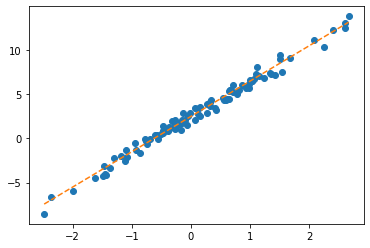

In [3]:
plt.plot(x,y,'o')
plt.plot(x,ytrue,'--')
# 주황색 점선이 찾고자 하는 true 값
# 파란색 점들은 관측값

### 학습이란?

`-` 파란점만 주어졌을때, 주황색 점선을 추론하는것. 좀 더 정확하게 말하면 given data로 $\begin{bmatrix} \hat{w}_0 \\ \hat{w}_1 \end{bmatrix}$를 최대한 $\begin{bmatrix} 2.5 \\ 4 \end{bmatrix}$와 비슷하게 찾는것. 

- given data : $\big\{(x_i,y_i) \big\}_{i=1}^{n}$

- parameter: ${\bf W}=\begin{bmatrix} w_0 \\ w_1 \end{bmatrix}$

- estimated parameter: ${\bf \hat{W}}=\begin{bmatrix} \hat{w}_0 \\ \hat{w}_1 \end{bmatrix}$

`-` 더 쉽게 말하면 아래의 그림을 보고 `적당한` 추세선을 찾는것이다. 

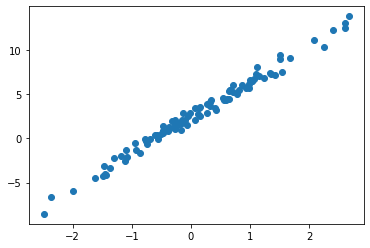

In [4]:
plt.plot(x,y,'o')

`-` 시도: $(\hat{w}_0,\hat{w}_1)=(-5,10)$을 선택하여 선을 그려보고 적당한지 판단. 

- $\hat{y}_i=-5 +10 x_i$ 와 같이 $y_i$의 값을 적합시키겠다는 의미 

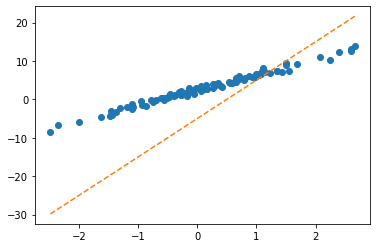

In [5]:
plt.plot(x,y,'o')
plt.plot(x,-5+10*x,'--')

`-` 벡터표현으로 주황색점선을 계산 

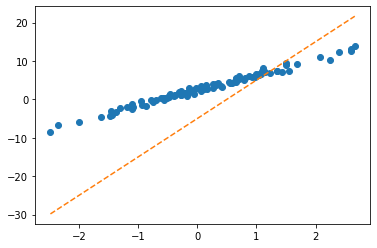

In [6]:
What=torch.tensor([-5.0,10.0])
plt.plot(x,y,'o')
plt.plot(x,X@What,'--')

### 파라메터를 학습하는 방법 (적당한 선으로 업데이트 하는 방법) 

`-` 이론적으로 추론 <- 회귀분석시간에 배운것

`-` **컴퓨터의 반복계산을 이용하여 추론 (경사하강법)** <- 우리가 오늘 파이토치로 실습해볼 내용. 

(1) initial value: 임의의 선을 일단 그어본다. 

In [7]:
What= torch.tensor([-5.0,10.0],requires_grad=True)
What

tensor([-5., 10.], requires_grad=True)

- 처음에는 ${\bf \hat{W}}=\begin{bmatrix} \hat{w}_0 \\ \hat{w}_1 \end{bmatrix}=\begin{bmatrix} -5 \\ 10 \end{bmatrix} $ 를 대입해서 주황색 점선을 적당히 그려보자는 의미 

- 끝에 requires_grad=True는 나중에 미분을 위한 것 

In [8]:
yhat=X@What
yhat
# 미분을 위한 requires_grad=True( 이하 미분 꼬리표 )로 설정된 변수와 설정되지 않은 변수를 사칙연산하면 설정된 변수로 변한다.

tensor([-29.8211, -28.6215, -24.9730, -21.2394, -19.7919, -19.6354, -19.5093,
        -19.4352, -18.7223, -18.0793, -16.9040, -16.0918, -16.0536, -15.8746,
        -14.4690, -14.3193, -13.6426, -12.8578, -12.5486, -12.4213, -11.9484,
        -11.1034, -10.8296, -10.6210, -10.5064, -10.0578,  -9.8063,  -9.7380,
         -9.7097,  -9.6756,  -8.8736,  -8.7195,  -8.6880,  -8.1592,  -7.7752,
         -7.7716,  -7.7339,  -7.7208,  -7.6677,  -7.1551,  -7.0004,  -6.8163,
         -6.7081,  -6.5655,  -6.4480,  -6.3612,  -6.0566,  -5.6031,  -5.5589,
         -5.2137,  -4.3446,  -4.3165,  -3.8047,  -3.5801,  -3.4793,  -3.4325,
         -2.3545,  -2.3440,  -1.8434,  -1.7799,  -1.5386,  -1.0161,  -0.8103,
          0.4426,   0.5794,   0.9125,   1.1483,   1.4687,   1.4690,   1.5234,
          1.6738,   2.0592,   2.1414,   2.8221,   3.1536,   3.6682,   4.2907,
          4.8037,   4.8531,   4.9414,   5.3757,   5.3926,   5.6973,   6.0239,
          6.1261,   6.5317,   7.2891,   8.4032,   8.4936,   9.27

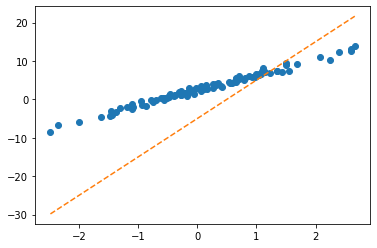

In [9]:
plt.plot(x,y,'o')
plt.plot(x,yhat.data,'--')
# yhat은 미분 꼬리표가 있는 데이터이므로 값만 도출하기 위해 yhat.data를 사용한다.

(2) 첫번째 수정: 적당한 선의 '적당한 정도'를 판단하고 더 적당한 선으로 업데이트 한다. 

`-` '적당한 정도'를 판단하기 위한 장치: loss function 도입!

$loss=\sum_{i=1}^{n}(y_i-\hat{y}_i)^2=\sum_{i=1}^{n}(y_i-(\hat{w}_0+\hat{w}_1x_i))^2$

$=({\bf y}-{\bf\hat{y}})^\top({\bf y}-{\bf\hat{y}})=({\bf y}-{\bf X}{\bf \hat{W}})^\top({\bf y}-{\bf X}{\bf \hat{W}})$

`-` loss 함수의 특징 
- $y_i \approx \hat{y}_i$ 일수록 loss값이 작다. 
- $y_i \approx \hat{y}_i$ 이 되도록 $(\hat{w}_0,\hat{w}_1)$을 잘 찍으면 loss값이 작다. 
- (중요) 주황색 점선이 '적당할 수록' loss값이 작다. 

In [10]:
#What= torch.tensor([-5.0,10.0],requires_grad=True)
loss=torch.sum((y-yhat)**2)
# 위는 loss=torch.sum((y-yhat)@(y-yhat)) 과 같다.
loss

tensor(8587.6875, grad_fn=<SumBackward0>)

`-` 우리의 목표: 이 loss(=8587.6875)을 더 줄이자. $\to$ 아예 모든 조합 $(\hat{w}_0,\hat{w}_1)$에 대하여 가장 작은 loss를 찾으면 좋겠다. 

`-` 문제의 치환: 생각해보니까 우리의 문제는 아래와 같이 수학적으로 단순화 되었다. 
- 적당해보이는 주황색 선을 찾자 $\to$ $loss(w_0,w_1)$를 최소로하는 $(w_0,w_1)$의 값을 찾자. 

`-` 수정된 목표: $loss(w_0,w_1)$를 최소로 하는 $(w_0,w_1)$을 구하라. 
- 단순한 수학문제가 되었다. 마치 $loss(w)=w^2-2w+3$ 을 최소화하는 $w$를 찾으라는 것과 같음. 

`-` 우리의 무기: 경사하강법, 벡터미분 

---

#### ($\ast$) 잠시 경사하강법을 리뷰하자. 

**경사하강법 아이디어 (1차원)**

(step 1) 임의의 점을 찍는다. 

(step 2) 그 점에서 순간기울기를 구한다. (접선) <-- 미분

(step 3) 순간기울기(=미분계수)의 부호를 살펴보고 부호와 반대방향으로 움직인다. (순간기울기와 같은 방향으로 움직이면 점점 커질테니까)

(팁) 기울기의 절대값 크기와 비례하여 보폭(=움직이는 정도)을 조절한다. 

**경사하강법 아이디어 (2차원)**

`-` 경사하강법 아이디어 (1차원) 


(step 1) 임의의 점을 찍는다. 

(step 2) 그 점에서 순간기울기를 구한다. (접평면) <-- 편미분

(step 3) 순간기울기(=미분계수)의 부호를 살펴보고 부호와 반대방향으로 변수 별로 각각 움직인다. (순간기울기와 같은 방향으로 움직이면 점점 커질테니까)

(팁) 기울기의 절대값 크기와 비례하여 보폭(=움직이는 정도)을 변수 별로 각각 조절한다. 

**loss를 줄이도록 ${\bf W}$를 개선하는 방법**

`-` $수정값 \leftarrow 원래값 - 기울어진크기(=미분계수) \times \alpha $

- 여기에서 $\alpha$는 전체적인 보폭의 크기를 결정한다. 즉 $\alpha$값이 클수록 한번의 update에 움직이는 양이 크다. 

`-` ${\bf W} \leftarrow {\bf W} - \alpha \times \frac{\partial}{\partial {\bf W}}loss(w_0,w_1)$

- 마이너스의 의미: 기울기의 부호를 보고 반대방향으로 움직여라. 

- $\frac{\partial}{\partial {\bf W}}loss(w_0,w_1):$ 기울기의 절대값 크기와 비례하여 움직이는 정도를 조정하라. 

- $\alpha$의 의미: 전체적인 보폭의 속도를 조절, $\alpha$가 크면 전체적으로 빠르게 움직인다. 다리의 길이로 비유할 수 있다. 

---

`-` 우리의 목표: loss=8587.6875 인데, 이걸 줄이는 것이 목표라고 했었음. 이것을 줄이는 방법이 경사하강법이다. 

`-` 경사하강법으로 loss를 줄이기 위해서는 $\frac{\partial}{\partial {\bf W}}loss(w_0,w_1)$의 계산이 필요한데, 이를 위해서 벡터미분이 필요하다. 

In [11]:
loss.backward()
# 미분을 해주는 함수 backward

- 미분해라! 뭘로? `requires_grad=True`를 가진 텐서로!!
```python
loss=torch.sum((y-yhat)**2)= torch.sum((y-X@What)**2)
# 이었고 
What=torch.tensor([-5.0,10.0],requires_grad=True)
# 이므로 결국 What으로 미분하라는 의미. 
# 미분한 식이 나오는 것이 아니고, 
# 그 식에 (-5.0, 10.0)을 대입한 계수값이 계산됨. 
```

- 정확하게 말하면 미분을 활용하여 $(-5,10)$에서의 순간기울기를 구했다는 의미임. 

In [12]:
What.grad.data

tensor([-1342.2522,  1188.9305])

- 이것이 의미하는건 $(-5,10)$에서 loss function의 순간기울기가 $(-1342.2523, 1188.9307)$ 이라는 의미

`-` 잘계산한것이 맞는가? 손계산으로 검증하여 보자. 

- $loss(w_0,w_1)=(y-\hat{y})^\top (y-\hat{y})=(y-XW)^\top (y-XW)$

- $\frac{\partial}{\partial W}loss(w_0,w_1)=-2X^\top y+2X^\top X W$

In [13]:
- 2 * X.T @ y + 2 * X.T @ X @ What

tensor([-1342.2523,  1188.9305], grad_fn=<AddBackward0>)

In [14]:
alpha=0.001 
print('수정전: ' + str(What.data))
print('수정하는폭: ' +str(-alpha * What.grad.data))
print('수정후: ' +str(What.data-alpha * What.grad.data))
print('*참값: (2.5,4)' )

수정전: tensor([-5., 10.])
수정하는폭: tensor([ 1.3423, -1.1889])
수정후: tensor([-3.6577,  8.8111])
*참값: (2.5,4)


In [15]:
Wbefore = What.data
Wafter = What.data-alpha * What.grad.data 
Wbefore, Wafter

(tensor([-5., 10.]), tensor([-3.6577,  8.8111]))

Text(0.5, 1.0, 'before: blue // after: red')

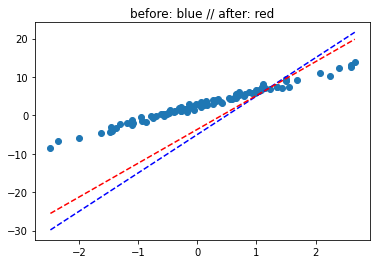

In [16]:
plt.plot(x,y,'o')
plt.plot(x,X@Wbefore,'--',color='b') #수정전: 파란점선
plt.plot(x,X@Wafter,'--',color='r') #수정후: 빨간점선
plt.title("before: blue // after: red")

(3) Learn (=estimate $\bf\hat{W})$: 

In [17]:
What= torch.tensor([-5.0,10.0],requires_grad=True)

In [18]:
alpha=0.001 
for epoc in range(30): 
    What.grad=None # 변수 비우기 
    yhat=X@What 
    loss=torch.sum((y-yhat)**2)
    loss.backward() 
    What.data = What.data-alpha * What.grad.data 

In [19]:
What.data ## true: (2.5,4) 

tensor([2.4290, 4.0144])

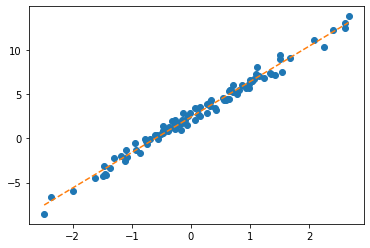

In [20]:
plt.plot(x,y,'o')
plt.plot(x,(X@What.data),'--')
# plt.plot(x,(X@What),'--') 로 입력할 경우 미분 꼬리표가 붙어있는 상태이기 때문에 에러가 발생한다.

### 파라메터의 수정과정을 관찰할 수 없을까? (학습과정 모니터링) 

`-` 기록을 해보자. 

In [21]:
losses = [] # 기록하고 싶은것 1  
yhats = [] # 기록하고 싶은것 2 
Whats = [] # 기록하고 싶은것 3 

In [22]:
What= torch.tensor([-5.0,10.0],requires_grad=True)
alpha=0.001 
for epoc in range(30): 
    Whats=Whats+[What.data.tolist()] # 기록 1
    What.grad=None
    yhat=X@What 
    yhats=yhats+[yhat.data.tolist()] # 기록 2
    loss=torch.sum((y-yhat)**2)
    losses = losses + [loss.item()] # 기록 3
    loss.backward() 
    What.data = What.data-alpha * What.grad.data 

`-` $\hat{y}$ 관찰 

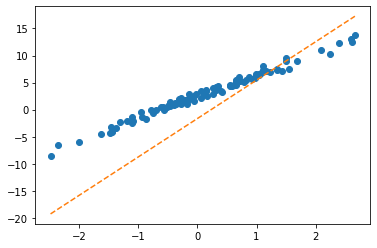

In [23]:
plt.plot(x,y,'o')
plt.plot(x,yhats[3],'--')

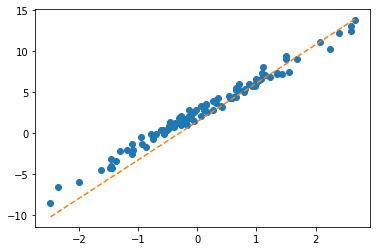

In [24]:
plt.plot(x,y,'o')
plt.plot(x,yhats[10],'--')

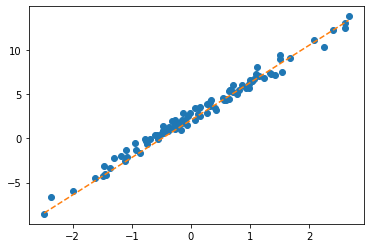

In [25]:
plt.plot(x,y,'o')
plt.plot(x,yhats[15],'--')

`-` $\hat{\bf W}$ 

In [26]:
Whats

[[-5.0, 10.0],
 [-3.657747745513916, 8.81106948852539],
 [-2.554811477661133, 7.861191749572754],
 [-1.649186134338379, 7.101552963256836],
 [-0.9060712456703186, 6.49347448348999],
 [-0.2966785430908203, 6.006272315979004],
 [0.20277434587478638, 5.615575313568115],
 [0.6119105815887451, 5.302003383636475],
 [0.9469034671783447, 5.050129413604736],
 [1.2210699319839478, 4.847657680511475],
 [1.4453645944595337, 4.684779167175293],
 [1.6287915706634521, 4.553659439086914],
 [1.778746247291565, 4.448036193847656],
 [1.90129816532135, 4.3628973960876465],
 [2.0014259815216064, 4.294229507446289],
 [2.0832109451293945, 4.238814353942871],
 [2.149996757507324, 4.194070339202881],
 [2.204521894454956, 4.157923698425293],
 [2.249027729034424, 4.128708839416504],
 [2.285348415374756, 4.105085849761963],
 [2.31498384475708, 4.0859761238098145],
 [2.339160442352295, 4.070511341094971],
 [2.3588807582855225, 4.057991027832031],
 [2.3749637603759766, 4.0478515625],
 [2.3880786895751953, 4.0396370

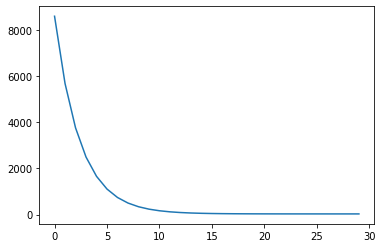

In [27]:
plt.plot(losses)

### Animation 

In [28]:
plt.rcParams['figure.figsize'] = (20,8) # 그림의 크기 
plt.rcParams["animation.html"] = "jshtml" 

In [29]:
from matplotlib import animation

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

## ax1: 왼쪽그림 
ax1.plot(x,y,'o')
line, = ax1.plot(x,yhats[0]) 
## ax2: 오른쪽그림 
_w0 = np.arange(-6, 11, 0.5) ## 파란색곡면을 그리는 코드 (시작) 
_w1 = np.arange(-6, 11, 0.5)
w1,w0 = np.meshgrid(_w1,_w0)
l=w0*0
for i in range(len(_w0)):
    for j in range(len(_w1)):
        l[i,j]=torch.sum((y-_w0[i]-_w1[j]*x)**2)
ax2.plot_surface(w0, w1, l, rstride=1, cstride=1, color='b',alpha=0.35) ## 파란색곡면을 그리는 코드(끝) 
ax2.scatter(2.5,4,torch.sum((y-2.5-4*x)**2),s=200,color='red',marker='*') ## 최소점을 표시하는 코드 (붉은색 별) 
ax2.scatter(np.array(Whats)[0,0],np.array(Whats)[0,1],losses[0],color='b') ## 업데이트되는 What을 표시하는 점 (파란색 동그라미) 
ax2.azim = 40  ## 3d plot의 view 조절 
ax2.dist = 8   ## 3d plot의 view 조절 
ax2.elev = 5   ## 3d plot의 view 조절 

def animate(epoc):
    line.set_ydata(yhats[epoc])
    ax2.scatter(np.array(Whats)[epoc,0],np.array(Whats)[epoc,1],losses[epoc],color='grey')
    return line

ani = animation.FuncAnimation(fig, animate, frames=30)
plt.close()
ani

Output hidden; open in https://colab.research.google.com to view.

`-` 왼쪽 plot은 지금까지 했던 과정과 같고 

`-` 오른쪽 plot은 우리가 이 문제를 치환하고자 하는 모습

#### $\alpha$에 대하여 ($\alpha$는 학습률) 

(1) $\alpha$가 너무 작다면? $\to$ 비효율적이다. 

In [30]:
losses = [] # 기록하고 싶은것 1  
yhats = [] # 기록하고 싶은것 2 
Whats = [] # 기록하고 싶은것 3 

In [31]:
alpha=0.0001 

What= torch.tensor([-5.0,10.0],requires_grad=True)
for epoc in range(30): 
    Whats=Whats+[What.data.tolist()] 
    What.grad=None
    yhat=X@What 
    yhats=yhats+[yhat.data.tolist()]
    loss=torch.sum((y-yhat)**2)
    losses = losses + [loss.item()]
    loss.backward() 
    What.data = What.data-alpha * What.grad.data 

In [32]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

## ax1: 왼쪽그림 
ax1.plot(x,y,'o')
line, = ax1.plot(x,yhats[0]) 
## ax2: 오른쪽그림 
_w0 = np.arange(-6, 11, 0.5) ## 파란색곡면을 그리는 코드 (시작) 
_w1 = np.arange(-6, 11, 0.5)
w1,w0 = np.meshgrid(_w1,_w0)
l=w0*0
for i in range(len(_w0)):
    for j in range(len(_w1)):
        l[i,j]=torch.sum((y-_w0[i]-_w1[j]*x)**2)
ax2.plot_surface(w0, w1, l, rstride=1, cstride=1, color='b',alpha=0.35) ## 파란색곡면을 그리는 코드(끝) 
ax2.scatter(2.5,4,torch.sum((y-2.5-4*x)**2),s=200,color='red',marker='*') ## 최소점을 표시하는 코드 (붉은색 별) 
ax2.scatter(np.array(Whats)[0,0],np.array(Whats)[0,1],losses[0],color='b') ## 업데이트되는 What을 표시하는 점 (파란색 동그라미) 
ax2.azim = 40  ## 3d plot의 view 조절 
ax2.dist = 8   ## 3d plot의 view 조절 
ax2.elev = 5   ## 3d plot의 view 조절 

def animate(epoc):
    line.set_ydata(yhats[epoc])
    ax2.scatter(np.array(Whats)[epoc,0],np.array(Whats)[epoc,1],losses[epoc],color='grey')
    return line

ani = animation.FuncAnimation(fig, animate, frames=30)
plt.close()
ani

Output hidden; open in https://colab.research.google.com to view.

(2) $\alpha$가 크다면? $\to$ 다른의미에서 비효율적이다 + 위험하다.. 

In [33]:
losses = [] # 기록하고 싶은것 1  
yhats = [] # 기록하고 싶은것 2 
Whats = [] # 기록하고 싶은것 3 

In [34]:
alpha=0.0083  

What= torch.tensor([-5.0,10.0],requires_grad=True)
for epoc in range(30): 
    Whats=Whats+[What.data.tolist()] 
    What.grad=None
    yhat=X@What 
    yhats=yhats+[yhat.data.tolist()]
    loss=torch.sum((y-yhat)**2)
    losses = losses + [loss.item()]
    loss.backward() 
    What.data = What.data-alpha * What.grad.data 

In [35]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

## ax1: 왼쪽그림 
ax1.plot(x,y,'o')
line, = ax1.plot(x,yhats[0]) 
## ax2: 오른쪽그림 
_w0 = np.arange(-6, 11, 0.5) ## 파란색곡면을 그리는 코드 (시작) 
_w1 = np.arange(-6, 11, 0.5)
w1,w0 = np.meshgrid(_w1,_w0)
l=w0*0
for i in range(len(_w0)):
    for j in range(len(_w1)):
        l[i,j]=torch.sum((y-_w0[i]-_w1[j]*x)**2)
ax2.plot_surface(w0, w1, l, rstride=1, cstride=1, color='b',alpha=0.35) ## 파란색곡면을 그리는 코드(끝) 
ax2.scatter(2.5,4,torch.sum((y-2.5-4*x)**2),s=200,color='red',marker='*') ## 최소점을 표시하는 코드 (붉은색 별) 
ax2.scatter(np.array(Whats)[0,0],np.array(Whats)[0,1],losses[0],color='b') ## 업데이트되는 What을 표시하는 점 (파란색 동그라미) 
ax2.azim = 40  ## 3d plot의 view 조절 
ax2.dist = 8   ## 3d plot의 view 조절 
ax2.elev = 5   ## 3d plot의 view 조절 

def animate(epoc):
    line.set_ydata(yhats[epoc])
    ax2.scatter(np.array(Whats)[epoc,0],np.array(Whats)[epoc,1],losses[epoc],color='grey')
    return line

ani = animation.FuncAnimation(fig, animate, frames=30)
plt.close()
ani

Output hidden; open in https://colab.research.google.com to view.

(3) $\alpha=0.0085$

In [36]:
losses = [] # 기록하고 싶은것 1  
yhats = [] # 기록하고 싶은것 2 
Whats = [] # 기록하고 싶은것 3 

In [37]:
alpha=0.0085 

What= torch.tensor([-5.0,10.0],requires_grad=True)
for epoc in range(30): 
    Whats=Whats+[What.data.tolist()] 
    What.grad=None
    yhat=X@What 
    yhats=yhats+[yhat.data.tolist()]
    loss=torch.sum((y-yhat)**2)
    losses = losses + [loss.item()]
    loss.backward() 
    What.data = What.data-alpha * What.grad.data 

In [38]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

## ax1: 왼쪽그림 
ax1.plot(x,y,'o')
line, = ax1.plot(x,yhats[0]) 
## ax2: 오른쪽그림 
_w0 = np.arange(-6, 11, 0.5) ## 파란색곡면을 그리는 코드 (시작) 
_w1 = np.arange(-6, 11, 0.5)
w1,w0 = np.meshgrid(_w1,_w0)
l=w0*0
for i in range(len(_w0)):
    for j in range(len(_w1)):
        l[i,j]=torch.sum((y-_w0[i]-_w1[j]*x)**2)
ax2.plot_surface(w0, w1, l, rstride=1, cstride=1, color='b',alpha=0.35) ## 파란색곡면을 그리는 코드(끝) 
ax2.scatter(2.5,4,torch.sum((y-2.5-4*x)**2),s=200,color='red',marker='*') ## 최소점을 표시하는 코드 (붉은색 별) 
ax2.scatter(np.array(Whats)[0,0],np.array(Whats)[0,1],losses[0],color='b') ## 업데이트되는 What을 표시하는 점 (파란색 동그라미) 
ax2.azim = 40  ## 3d plot의 view 조절 
ax2.dist = 8   ## 3d plot의 view 조절 
ax2.elev = 5   ## 3d plot의 view 조절 

def animate(epoc):
    line.set_ydata(yhats[epoc])
    ax2.scatter(np.array(Whats)[epoc,0],np.array(Whats)[epoc,1],losses[epoc],color='grey')
    return line

ani = animation.FuncAnimation(fig, animate, frames=30)
plt.close()
ani

Output hidden; open in https://colab.research.google.com to view.

(4) $\alpha=0.01$

In [39]:
losses = [] # 기록하고 싶은것 1  
yhats = [] # 기록하고 싶은것 2 
Whats = [] # 기록하고 싶은것 3 

In [40]:
alpha=0.01

What= torch.tensor([-5.0,10.0],requires_grad=True)
for epoc in range(30): 
    Whats=Whats+[What.data.tolist()] 
    What.grad=None
    yhat=X@What 
    yhats=yhats+[yhat.data.tolist()]
    loss=torch.sum((y-yhat)**2)
    losses = losses + [loss.item()]
    loss.backward() 
    What.data = What.data-alpha * What.grad.data 

In [41]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

## ax1: 왼쪽그림 
ax1.plot(x,y,'o')
line, = ax1.plot(x,yhats[0]) 
## ax2: 오른쪽그림 
_w0 = np.arange(-6, 11, 0.5) ## 파란색곡면을 그리는 코드 (시작) 
_w1 = np.arange(-6, 11, 0.5)
w1,w0 = np.meshgrid(_w1,_w0)
l=w0*0
for i in range(len(_w0)):
    for j in range(len(_w1)):
        l[i,j]=torch.sum((y-_w0[i]-_w1[j]*x)**2)
ax2.plot_surface(w0, w1, l, rstride=1, cstride=1, color='b',alpha=0.35) ## 파란색곡면을 그리는 코드(끝) 
ax2.scatter(2.5,4,torch.sum((y-2.5-4*x)**2),s=200,color='red',marker='*') ## 최소점을 표시하는 코드 (붉은색 별) 
ax2.scatter(np.array(Whats)[0,0],np.array(Whats)[0,1],losses[0],color='b') ## 업데이트되는 What을 표시하는 점 (파란색 동그라미) 
ax2.azim = 40  ## 3d plot의 view 조절 
ax2.dist = 8   ## 3d plot의 view 조절 
ax2.elev = 5   ## 3d plot의 view 조절 

def animate(epoc):
    line.set_ydata(yhats[epoc])
    ax2.scatter(np.array(Whats)[epoc,0],np.array(Whats)[epoc,1],losses[epoc],color='grey')
    return line

ani = animation.FuncAnimation(fig, animate, frames=30)
plt.close()
ani

Output hidden; open in https://colab.research.google.com to view.

`-` 오히려 loss가 늘어난다

### [숙제](https://ieilms.jbnu.ac.kr/)

`-` 학습률($\alpha$)를 조정하며 실습해보고 스크린샷 제출 

수업에서 사용했었던 값들 중 적당한 값의 평균인 아래 값을 사용해보겠습니다.

$\frac{0.0001+0.001}{2} = 0.00055$

## $\alpha = 0.00055$

In [42]:
losses = [] # 기록하고 싶은것 1  
yhats = [] # 기록하고 싶은것 2 
Whats = [] # 기록하고 싶은것 3 

In [43]:
alpha=0.00055

What= torch.tensor([-5.0,10.0],requires_grad=True)
for epoc in range(30): 
    Whats=Whats+[What.data.tolist()] 
    What.grad=None
    yhat=X@What 
    yhats=yhats+[yhat.data.tolist()]
    loss=torch.sum((y-yhat)**2)
    losses = losses + [loss.item()]
    loss.backward() 
    What.data = What.data-alpha * What.grad.data 

In [44]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

## ax1: 왼쪽그림 
ax1.plot(x,y,'o')
line, = ax1.plot(x,yhats[0]) 
## ax2: 오른쪽그림 
_w0 = np.arange(-6, 11, 0.5) ## 파란색곡면을 그리는 코드 (시작) 
_w1 = np.arange(-6, 11, 0.5)
w1,w0 = np.meshgrid(_w1,_w0)
l=w0*0
for i in range(len(_w0)):
    for j in range(len(_w1)):
        l[i,j]=torch.sum((y-_w0[i]-_w1[j]*x)**2)
ax2.plot_surface(w0, w1, l, rstride=1, cstride=1, color='b',alpha=0.35) ## 파란색곡면을 그리는 코드(끝) 
ax2.scatter(2.5,4,torch.sum((y-2.5-4*x)**2),s=200,color='red',marker='*') ## 최소점을 표시하는 코드 (붉은색 별) 
ax2.scatter(np.array(Whats)[0,0],np.array(Whats)[0,1],losses[0],color='b') ## 업데이트되는 What을 표시하는 점 (파란색 동그라미) 
ax2.azim = 40  ## 3d plot의 view 조절 
ax2.dist = 8   ## 3d plot의 view 조절 
ax2.elev = 5   ## 3d plot의 view 조절 

def animate(epoc):
    line.set_ydata(yhats[epoc])
    ax2.scatter(np.array(Whats)[epoc,0],np.array(Whats)[epoc,1],losses[epoc],color='grey')
    return line

ani = animation.FuncAnimation(fig, animate, frames=30)
plt.close()
ani

Output hidden; open in https://colab.research.google.com to view.

## (2) $\alpha = 0.003$

In [45]:
losses = [] # 기록하고 싶은것 1  
yhats = [] # 기록하고 싶은것 2 
Whats = [] # 기록하고 싶은것 3 

In [46]:
alpha=0.00055

What= torch.tensor([-5.0,10.0],requires_grad=True)
for epoc in range(30): 
    Whats=Whats+[What.data.tolist()] 
    What.grad=None
    yhat=X@What 
    yhats=yhats+[yhat.data.tolist()]
    loss=torch.sum((y-yhat)**2)
    losses = losses + [loss.item()]
    loss.backward() 
    What.data = What.data-alpha * What.grad.data 

In [47]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

## ax1: 왼쪽그림 
ax1.plot(x,y,'o')
line, = ax1.plot(x,yhats[0]) 
## ax2: 오른쪽그림 
_w0 = np.arange(-6, 11, 0.5) ## 파란색곡면을 그리는 코드 (시작) 
_w1 = np.arange(-6, 11, 0.5)
w1,w0 = np.meshgrid(_w1,_w0)
l=w0*0
for i in range(len(_w0)):
    for j in range(len(_w1)):
        l[i,j]=torch.sum((y-_w0[i]-_w1[j]*x)**2)
ax2.plot_surface(w0, w1, l, rstride=1, cstride=1, color='b',alpha=0.35) ## 파란색곡면을 그리는 코드(끝) 
ax2.scatter(2.5,4,torch.sum((y-2.5-4*x)**2),s=200,color='red',marker='*') ## 최소점을 표시하는 코드 (붉은색 별) 
ax2.scatter(np.array(Whats)[0,0],np.array(Whats)[0,1],losses[0],color='b') ## 업데이트되는 What을 표시하는 점 (파란색 동그라미) 
ax2.azim = 40  ## 3d plot의 view 조절 
ax2.dist = 8   ## 3d plot의 view 조절 
ax2.elev = 5   ## 3d plot의 view 조절 

def animate(epoc):
    line.set_ydata(yhats[epoc])
    ax2.scatter(np.array(Whats)[epoc,0],np.array(Whats)[epoc,1],losses[epoc],color='grey')
    return line

ani = animation.FuncAnimation(fig, animate, frames=30)
plt.close()
ani

Output hidden; open in https://colab.research.google.com to view.

## (3) $\alpha = 0.00665$

In [48]:
losses = [] # 기록하고 싶은것 1  
yhats = [] # 기록하고 싶은것 2 
Whats = [] # 기록하고 싶은것 3 

In [49]:
alpha=0.00055

What= torch.tensor([-5.0,10.0],requires_grad=True)
for epoc in range(30): 
    Whats=Whats+[What.data.tolist()] 
    What.grad=None
    yhat=X@What 
    yhats=yhats+[yhat.data.tolist()]
    loss=torch.sum((y-yhat)**2)
    losses = losses + [loss.item()]
    loss.backward() 
    What.data = What.data-alpha * What.grad.data 

In [50]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

## ax1: 왼쪽그림 
ax1.plot(x,y,'o')
line, = ax1.plot(x,yhats[0]) 
## ax2: 오른쪽그림 
_w0 = np.arange(-6, 11, 0.5) ## 파란색곡면을 그리는 코드 (시작) 
_w1 = np.arange(-6, 11, 0.5)
w1,w0 = np.meshgrid(_w1,_w0)
l=w0*0
for i in range(len(_w0)):
    for j in range(len(_w1)):
        l[i,j]=torch.sum((y-_w0[i]-_w1[j]*x)**2)
ax2.plot_surface(w0, w1, l, rstride=1, cstride=1, color='b',alpha=0.35) ## 파란색곡면을 그리는 코드(끝) 
ax2.scatter(2.5,4,torch.sum((y-2.5-4*x)**2),s=200,color='red',marker='*') ## 최소점을 표시하는 코드 (붉은색 별) 
ax2.scatter(np.array(Whats)[0,0],np.array(Whats)[0,1],losses[0],color='b') ## 업데이트되는 What을 표시하는 점 (파란색 동그라미) 
ax2.azim = 40  ## 3d plot의 view 조절 
ax2.dist = 8   ## 3d plot의 view 조절 
ax2.elev = 5   ## 3d plot의 view 조절 

def animate(epoc):
    line.set_ydata(yhats[epoc])
    ax2.scatter(np.array(Whats)[epoc,0],np.array(Whats)[epoc,1],losses[epoc],color='grey')
    return line

ani = animation.FuncAnimation(fig, animate, frames=30)
plt.close()
ani

Output hidden; open in https://colab.research.google.com to view.